# Project 3 : image denoising and reconstruction
## Part I : Image denoising

In [1]:
import numpy as np
from matplotlib import image
from matplotlib import pyplot
from numpy import random as rnd
import cvxpy as cp
from numpy import linalg as lg
import matplotlib.pyplot as plt

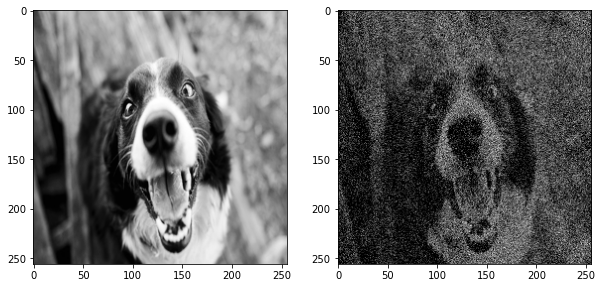

In [2]:
dog = image.imread('dog.png')

dog_noisy = dog + .3*rnd.normal(size=(dog.shape[0],dog.shape[1]))
dog_noisy[dog_noisy>255] = 255
dog_noisy[dog_noisy<0] = 0

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(dog, cmap='gray')
ax[1].imshow(dog_noisy, cmap='gray')

In [3]:
n = 256
rho = 5e-3
X = cp.Variable((n,n))
Y = cp.Variable((n-1,n))
Z = cp.Variable((n,n-1))
t = cp.Variable(1)

objective = cp.Minimize(t + rho*(cp.sum(Y) + cp.sum(Z)))

constraints = []

constraints.append(cp.norm(cp.vec(X) - cp.vec(dog_noisy),2) <= t)
constraints.extend([(-Y <= X[1:,:] - dog_noisy[:n-1,:]) , (X[1:,:] - dog_noisy[:n-1,:] <= Y)])
constraints.extend([(-Z <= X[:,1:] - dog_noisy[:,:n-1]) , (X[:,1:] - dog_noisy[:,:n-1] <= Z)])

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK)

160.7934101743728

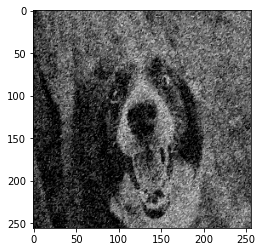

In [4]:
pyplot.imshow(X.value, cmap='gray')
pyplot.show()

In [89]:
f = lambda X, X_true, X_noisy: lg.norm(X - X_true, 'fro')/lg.norm(X_noisy - X_true,'fro')

space = np.logspace(-4,-1,40)
f_val = np.empty(shape=[40])
i = 0

for rho in space:
    objective = cp.Minimize(t + rho*(cp.sum(Y) + cp.sum(Z)))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK)
    f_val[i] = f(X.value,dog,dog_noisy)
    i += 1

(Text(0.5, 0, '$\\rho$'), Text(0, 0.5, '$f(\\rho)$'))

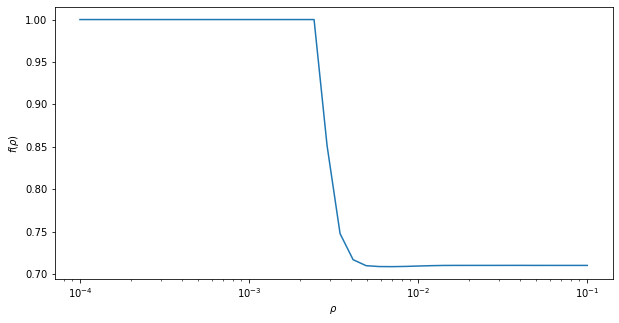

In [97]:
fig = plt.figure(figsize=(10,5))
plt.semilogx(space,f_val)
plt.xlabel(r'$\rho$'), plt.ylabel(r'$f(\rho)$')

## Part II : image reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


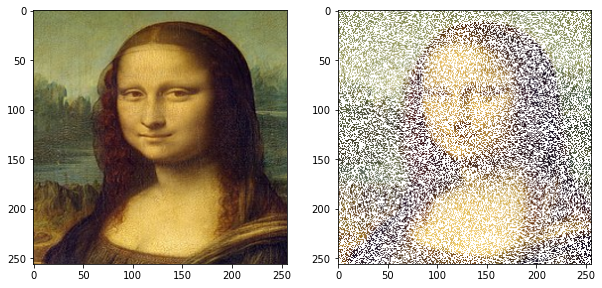

In [128]:
monalisa = image.imread('monalisa.png')

# Hide pixels
monalisa_partial = 255*np.ones(shape=[256,256,3])
keep_pixels = rnd.random((256,256))
monalisa_partial[keep_pixels < .4,:] = monalisa[keep_pixels < .4,:]

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(monalisa)
ax[1].imshow(monalisa_partial)

In [157]:
import itertools
# Optimisation problem
m = 256
k = 3 # Third dimension
X = {} # Create dictionary to mimic 3 dimensions variable
for i in range(k):
    X[i] = cp.Variable((m,m))
    
X_diff_hor, X_diff_vert = 0, 0
    
for i in range(k):
    X_diff_hor += cp.sum(X[i][:,1:] - X[i][:,:m-1])
    X_diff_vert += cp.sum(X[i][1:,:] - X[i][:m-1,:])
    
constraints = []
for i in range(k):
    constraints.append(X[i][keep_pixels < .4] == monalisa_partial[keep_pixels < .4,i])

objective = cp.Minimize(X_diff_hor + X_diff_vert)

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK)

-inf